In [ ]:
!pip install torch torchvision torchaudio -q
!pip install torch-geometric -q
!pip install networkx matplotlib seaborn -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00


In [ ]:
!gunzip -k amazon0302.txt.gz


In [ ]:
!ls -l
!head -n 10 amazon0302.txt

total 21400
-rw-r--r-- 1 root root 17243811 Oct 16 14:17 amazon0302.txt
-rw-r--r-- 1 root root  4664334 Oct 16 14:17 amazon0302.txt.gz
drwxr-xr-x 1 root root     4096 Oct 14 13:41 sample_data
# Directed graph (each unordered pair of nodes is saved once): Amazon0302.txt 
# Amazon product co-purchaisng network from March 02 2003
# Nodes: 262111 Edges: 1234877
# FromNodeId	ToNodeId
0	1
0	2
0	3
0	4
0	5
1	0


In [ ]:
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GATv2Conv, LayerNorm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

# 1. Load edge list (skip '#' comments)
G = nx.read_edgelist('amazon0302.txt', comments='#', nodetype=int, create_using=nx.Graph())
print(f"NetworkX Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 2. Convert to PyG Data
data = from_networkx(G)
print(data)          # includes edge_index but no x,y yet

# 3. Relabel nodes 0..N-1 if needed
num_nodes = G.number_of_nodes()
print("num_nodes:", num_nodes)


NetworkX Graph: 262111 nodes, 899792 edges
Data(edge_index=[2, 1799584], num_nodes=262111)
num_nodes: 262111


In [ ]:
# Random 64-dim features
feat_dim = 64
data.x = torch.randn(num_nodes, feat_dim)

# Synthetic labels for demonstration (e.g., 10 classes)
num_classes = 10
data.y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

# Simple split masks
perm = torch.randperm(num_nodes)
ntrain = int(0.6 * num_nodes)
nval   = int(0.2 * num_nodes)
train_idx = perm[:ntrain]
val_idx   = perm[ntrain:ntrain+nval]
test_idx  = perm[ntrain+nval:]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool); data.train_mask[train_idx] = True
data.val_mask   = torch.zeros(num_nodes, dtype=torch.bool); data.val_mask[val_idx] = True
data.test_mask  = torch.zeros(num_nodes, dtype=torch.bool); data.test_mask[test_idx] = True


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GATv2Conv, LayerNorm

class GATv2NetResidual(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.6):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True)
        self.norm1 = LayerNorm(hidden_channels * heads)
        self.lin1 = nn.Linear(in_channels, hidden_channels * heads)  # for residual

        self.conv2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.norm2 = LayerNorm(out_channels)

        self.dropout = dropout

    def forward(self, x, edge_index):
        # First layer with residual
        h1 = self.conv1(x, edge_index)
        h1 = self.norm1(h1 + self.lin1(x))   # residual + normalization
        h1 = F.elu(h1)
        h1 = F.dropout(h1, p=self.dropout, training=self.training)

        # Second layer with residual (linear skip can be identity since dim matches)
        h2 = self.conv2(h1, edge_index)
        # Add residual by projecting input to output dim using linear if needed (here input h1 dim != output dim)
        # For simplicity, skip residual on output layer or implement if dims align.
        h2 = self.norm2(h2)
        out = F.log_softmax(h2, dim=1)
        return out


# Helper to get attention from a single conv call (PyG returns (out, (edge_index, attn_weights)))
def conv_with_attention(conv_layer, x, edge_index):
    # PyG GATv2Conv supports return_attention_weights=True
    out, (edge_idx, attn) = conv_layer(x, edge_index, return_attention_weights=True)
    return out, edge_idx, attn


In [ ]:
def train_epoch2(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate2(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = out.argmax(dim=1)
    acc_train = (preds[data.train_mask] == data.y[data.train_mask]).float().mean().item()
    acc_val = (preds[data.val_mask] == data.y[data.val_mask]).float().mean().item()
    acc_test = (preds[data.test_mask] == data.y[data.test_mask]).float().mean().item()
    return acc_train, acc_val, acc_test

def train_and_evaluate(data, model, optimizer, criterion, epochs=100, patience=20):
    best_val = 0.0
    best_test = 0.0
    pat_counter = 0
    for epoch in range(1, epochs + 1):
        loss = train_epoch2(model, data, optimizer, criterion)
        _, acc_val, acc_test = evaluate2(model, data)
        if acc_val > best_val:
            best_val = acc_val
            best_test = acc_test
            pat_counter = 0
            torch.save(model.state_dict(), 'best_gatv2.pth')
        else:
            pat_counter += 1
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val: {acc_val:.4f} | Test: {acc_test:.4f}")
        if pat_counter >= patience:
            print("Early stopping")
            break
    return best_val, best_test

lr_list = [0.001, 0.005, 0.01]
hidden_sizes = [8, 16, 32]
head_list = [2, 4, 8]

results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to device once outside loop since unchanged
data = data.to(device)

for lr in lr_list:
    for hs in hidden_sizes:
        for hd in head_list:
            print(f"\nTraining with lr={lr}, hidden={hs}, heads={hd}")
            model = GATv2NetResidual(feat_dim, hs, num_classes, heads=hd).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            criterion = nn.NLLLoss()
            best_val, best_test = train_and_evaluate(data, model, optimizer, criterion)
            results.append({
                'lr': lr,
                'hidden_size': hs,
                'heads': hd,
                'best_val_acc': best_val,
                'best_test_acc': best_test
            })

df_results = pd.DataFrame(results)




Training with lr=0.001, hidden=8, heads=2
Epoch 010 | Loss: 2.6643 | Val: 0.0983 | Test: 0.0997
Epoch 020 | Loss: 2.6088 | Val: 0.0978 | Test: 0.0971
Early stopping

Training with lr=0.001, hidden=8, heads=4
Epoch 010 | Loss: 2.6557 | Val: 0.0985 | Test: 0.0991
Epoch 020 | Loss: 2.5963 | Val: 0.0989 | Test: 0.0989
Early stopping

Training with lr=0.001, hidden=8, heads=8
Epoch 010 | Loss: 2.6574 | Val: 0.0985 | Test: 0.1004
Epoch 020 | Loss: 2.5908 | Val: 0.0979 | Test: 0.1017
Early stopping

Training with lr=0.001, hidden=16, heads=2
Epoch 010 | Loss: 2.6913 | Val: 0.0998 | Test: 0.1016
Epoch 020 | Loss: 2.6578 | Val: 0.0997 | Test: 0.1003
Epoch 030 | Loss: 2.6194 | Val: 0.0997 | Test: 0.0995
Early stopping

Training with lr=0.001, hidden=16, heads=4
Epoch 010 | Loss: 2.6783 | Val: 0.1017 | Test: 0.1009
Epoch 020 | Loss: 2.6186 | Val: 0.1005 | Test: 0.1017
Early stopping

Training with lr=0.001, hidden=16, heads=8
Epoch 010 | Loss: 2.6698 | Val: 0.0998 | Test: 0.0994
Epoch 020 | Loss

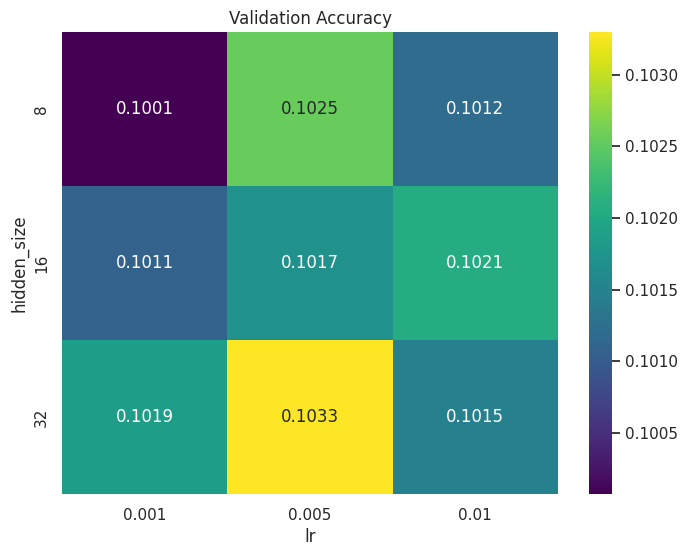

In [ ]:
grouped_df = df_results.groupby(['lr', 'hidden_size'], as_index=False).agg({'best_val_acc':'mean'})

# Plot heatmap for the grouped data
def plot_heatmap(df, metric, x_param, y_param, title):
    pivot = df.pivot(index=y_param, columns=x_param, values=metric)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
    plt.title(title)
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.show()

# Use the grouped DataFrame for plotting
plot_heatmap(grouped_df, 'best_val_acc', 'lr', 'hidden_size', 'Validation Accuracy')

Node 0 has 6 incoming edges.
Attention shape: (6,)


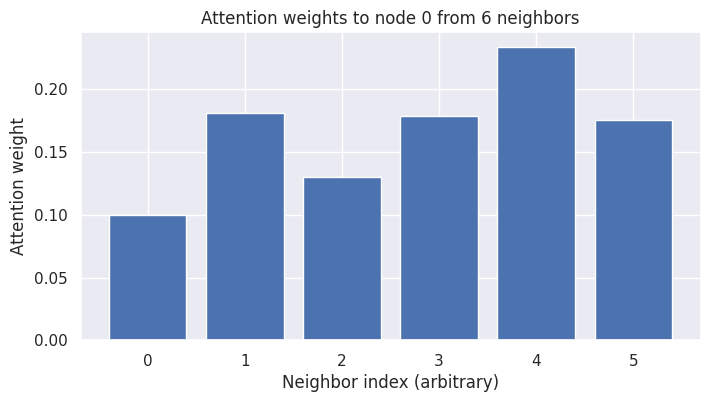

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# ----------------------------
# Helper: extract attention weights
# ----------------------------
def get_attention_map(model, data):
    model.eval()
    device = next(model.parameters()).device   # detect model device
    conv = model.conv1
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)

    with torch.no_grad():
        out, edge_idx, attn = conv_with_attention(conv, x, edge_index)

    edge_idx = edge_idx.cpu()
    attn = attn.cpu().detach()

    attn = attn.squeeze()
    if attn.dim() > 1:
        attn = attn.mean(dim=-1)

    return edge_idx, attn


# ----------------------------
# Get edge attention
# ----------------------------
edge_idx, attn = get_attention_map(model, data)

# ----------------------------
# Choose node for visualization
# ----------------------------
u = 0  # any node id
srcs = edge_idx[0].numpy()
tgts = edge_idx[1].numpy()

mask = (tgts == u)
src_nodes = srcs[mask]

# Convert attention values safely
attn_vals = attn[mask].numpy().flatten()

# Debug check
print(f"Node {u} has {len(src_nodes)} incoming edges.")
print(f"Attention shape: {attn_vals.shape}")

# ----------------------------
# Plot attention weights
# ----------------------------
if len(src_nodes) > 0 and len(attn_vals) == len(src_nodes):
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(src_nodes)), attn_vals)
    plt.xlabel('Neighbor index (arbitrary)')
    plt.ylabel('Attention weight')
    plt.title(f'Attention weights to node {u} from {len(src_nodes)} neighbors')
    plt.show()
else:
    print("⚠️ Shape mismatch — skipping plot.")
    print(f"src_nodes: {len(src_nodes)}, attn_vals: {len(attn_vals)}")
